In [1]:
# Always auto reload the functions from dependencies
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle, torch

# custom api
import dataset_api, signal_api

# Load Pulsation and Modulation ratios

In [3]:
with open('../data/RoR_dataset.pkl', 'rb') as file:
    RoR_dataset = pickle.load(file)
with open('../data/ratio_740_dataset.pkl', 'rb') as file:
    ratio_740_dataset = pickle.load(file)
with open('../data/ratio_850_dataset.pkl', 'rb') as file:
    ratio_850_dataset = pickle.load(file)
with open('../data/fsao2.pkl', 'rb') as file:
    SaO2_labels = pickle.load(file)
shp_rd_all = list(RoR_dataset.keys())

# Load Linear Interpolated fSaO2

In [4]:
good_fhr =    { 'S5_R1_su2020': (0, 42),
                'S5_R2_su2020': (0, 30),
                # 'S1_R1_sp2021': (0, 13),
                'S2_R2_sp2022': (13, 40),
                'S4_R2_sp2022': (0, 32)
                }

# Linear interpolation for SaO2 label to 1Hz
SaO2_labels_linear_interp = {}
for shp_rd in SaO2_labels.keys():
    timestamps = SaO2_labels[shp_rd][0]
    datapoints = SaO2_labels[shp_rd][1]
    per_second_timestamps = np.arange(timestamps[0]*60, timestamps[-1]*60+1)
    interpolated_datapoints = np.interp(per_second_timestamps, timestamps*60, datapoints)
    SaO2_labels_linear_interp[shp_rd] = (per_second_timestamps.astype(int), interpolated_datapoints)

## Average ratios for 90s window

In [5]:
def average_ratio(ratio, win_len=2.5):
    pad_width = int((win_len*80*60) // 2)
    padded_signal = []
    for i in range(5):
        padded_signal.append(np.pad(ratio[:,i], pad_width=pad_width, mode='edge'))
    padded_signal = np.column_stack(padded_signal)
    ratio_avg = []
    for i in range(len(ratio)//80):
        start_idx = i*80
        end_idx = i*80+2*pad_width
        ratio = np.mean(padded_signal[start_idx:end_idx], axis=0)
        ratio_avg.append(ratio)
    return np.array(ratio_avg)

# Average modulation ratios for both WLs
avg_ratio_740_dataset, avg_ratio_850_dataset = {}, {}
avg_RoR_dataset = {}
win_len = 1.5
for shp_rd in shp_rd_all:
    avg_ratio_740_dataset[shp_rd] = average_ratio(ratio_740_dataset[shp_rd], win_len=win_len)
    avg_ratio_850_dataset[shp_rd] = average_ratio(ratio_850_dataset[shp_rd], win_len=win_len)
    avg_RoR_dataset[shp_rd] = average_ratio(RoR_dataset[shp_rd], win_len=win_len)

# Discard bad FHR range
for shp_rd, good_range in good_fhr.items():
    start_idx, end_idx = good_range[0]*60, good_range[1]*60
    avg_ratio_740_dataset[shp_rd] = avg_ratio_740_dataset[shp_rd][start_idx:end_idx+1,:]
    avg_ratio_850_dataset[shp_rd] = avg_ratio_850_dataset[shp_rd][start_idx:end_idx+1,:]
    avg_RoR_dataset[shp_rd] = avg_RoR_dataset[shp_rd][start_idx:end_idx+1,:]

for shp_rd in shp_rd_all:
    print(f"Length of {shp_rd}: {len(avg_RoR_dataset[shp_rd])}")
total_length = sum(len(ror_data) for ror_data in avg_RoR_dataset.values())
print(f"Total length: {total_length}")

Length of S5_R1_su2020: 2521
Length of S5_R2_su2020: 1801
Length of S1_R3_sp2021: 1381
Length of S2_R2_sp2022: 1621
Length of S4_R1_sp2022: 3087
Length of S4_R2_sp2022: 1921
Length of S10_R1_sp2022: 2970
Length of S10_R2_sp2022: 1261
Total length: 16563


# FusionMLP for binary classification

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Network training and validation

In [7]:
from model import FusionMLP_bi_cla
from train_val import train_bi_cla, validation_bi_cla, validation_bi_cla_dict

# Initialize your model once
input_size, num_rep, cla_hidden_size, rep_hidden_size = 15, 5, 128, 16
initial_model = FusionMLP_bi_cla(input_size, num_rep, cla_hidden_size, rep_hidden_size).to(device)

def weights_init_he(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight.data)

initial_model.apply(weights_init_he)

# Save the entire model
layer_arch = 'FusionMLP2'
# torch.save(initial_model, f'../results/classification/{layer_arch}/{layer_arch}.pth')
with open(f'../results/classification/{layer_arch}/{layer_arch}.txt', 'w') as file:
    print(initial_model, file=file)

In [8]:
def plot_learning_curve(loss_history, file_path='../results/classification/FusionMLP1_learning_curve'):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(40,20))
    axs = axs.flatten()
    fig.delaxes(axs[-1])
    i = 0
    for iteration, item in loss_history.items():
        axs[i].plot(item['train_loss'], color='blue', label='train loss')
        axs[i].plot(item['test_loss'], color='orange', label = 'validation loss')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
        axs[i].set_title(f'{iteration}')
        i += 1
    fig.suptitle(f'learning curve (loss)', fontsize=20, y=0.95)
    # filename = f'{file_path}/fold_{fold+1}_loss'
    plt.savefig(file_path+'_loss', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(40,20))
    axs = axs.flatten()
    fig.delaxes(axs[-1])
    i = 0
    for iteration, item in loss_history.items():
        axs[i].plot(item['test_accuracy'], color='blue', label='test accuracy')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Accuracy')
        axs[i].legend()
        axs[i].set_title(f'{iteration}')
        i += 1
    fig.suptitle(f'learning curve (accuracy)', fontsize=20, y=0.95)
    # filename = f'{file_path}/fold_{fold+1}_loss'
    plt.savefig(file_path+'_accuracy', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight', pad_inches=0.1)


In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(['non-hypoxemic', 'hypoxemic'])
label_encoder.classes_ = label_encoder.classes_[::-1]

In [10]:
loaded_model = torch.load(f'../results/classification/{layer_arch}/{layer_arch}.pth')

shp_rd_all = ['S4_R1_sp2022',
              'S10_R1_sp2022',
                # 'S1_R1_sp2021',
                'S5_R1_su2020',
                'S2_R2_sp2022',
                'S5_R2_su2020',
                # 'S1_R2_sp2021',
                'S10_R2_sp2022',
                'S4_R2_sp2022',
                'S1_R3_sp2021',
                ]

# shp_rd_all = ['S4_R1_sp2022',
#                 # 'S1_R1_sp2021',
#                 'S5_R2_su2020',
#                 'S10_R1_sp2022',
                
#                 'S1_R2_sp2021',
#                 'S2_R2_sp2022',
#                 'S10_R2_sp2022',
                
#                 'S5_R1_su2020',
#                 'S4_R2_sp2022',
#                 'S1_R3_sp2021',
#                 ]

loss_history, loss_per_itr = {}, {}
iteration_acc_dict = {}
val_st_percentage = [0, 0.2, 0.4, 0.6, 0.8]
for iteration, st_ratio in enumerate(val_st_percentage):
  X_train, X_test, y_train, y_test, X_train_dict, y_train_dict, X_test_dict, y_test_dict = dataset_api.prepare_dataset(avg_ratio_740_dataset, avg_ratio_850_dataset, 
                      avg_RoR_dataset, SaO2_labels_linear_interp, shp_rd_all, label_encoder=label_encoder, val_ratio=0.2, val_st_per=st_ratio, verbose=0)
  
  model = FusionMLP_bi_cla(input_size, num_rep, cla_hidden_size, rep_hidden_size).to(device)
  model.load_state_dict(loaded_model.state_dict())

  model, train_loss, val_loss, accuracy, loss_history_itr = train_bi_cla(model, X_train, y_train, device=device, batch_size=32, X_test=X_test, y_test=y_test,
                                                                  val_patience=25)

  test_loss, test_mae = validation_bi_cla(model, X_test, y_test, device)
  test_loss_dict, test_acc_dict = validation_bi_cla_dict(model, X_test_dict, y_test_dict, device, verbose=0)

  loss_history[f'iteration{iteration+1}'] = loss_history_itr
  loss_per_itr[f'iteration{iteration+1}'] = {
      'train_loss': train_loss,
      'test_loss': test_loss,
      'test_accuracy': accuracy
  }
  iteration_acc_dict[f'iteration{iteration+1}'] = test_acc_dict
  torch.save(model.state_dict(), f'../results/classification/{layer_arch}/{layer_arch}_itr{iteration+1}.pth')

Epoch [1/300] - train loss: 2.4955e-01 - test loss: 2.6467e-01 - test accuracy: 75.24%
Epoch [2/300] - train loss: 1.3694e-01 - test loss: 2.6411e-01 - test accuracy: 81.63%
Epoch [3/300] - train loss: 9.4971e-02 - test loss: 2.6124e-01 - test accuracy: 83.66%
Epoch [4/300] - train loss: 6.9686e-02 - test loss: 2.5968e-01 - test accuracy: 83.78%
Epoch [5/300] - train loss: 5.2384e-02 - test loss: 2.6450e-01 - test accuracy: 84.10%
Epoch [6/300] - train loss: 4.1272e-02 - test loss: 2.8642e-01 - test accuracy: 82.00%
Epoch [7/300] - train loss: 3.2642e-02 - test loss: 2.9362e-01 - test accuracy: 83.17%
Epoch [8/300] - train loss: 2.6928e-02 - test loss: 3.2689e-01 - test accuracy: 81.92%
Epoch [9/300] - train loss: 2.2108e-02 - test loss: 3.3940e-01 - test accuracy: 81.84%
Epoch [10/300] - train loss: 1.8658e-02 - test loss: 3.5987e-01 - test accuracy: 81.80%
Epoch [11/300] - train loss: 1.5813e-02 - test loss: 3.8827e-01 - test accuracy: 82.77%
Epoch [12/300] - train loss: 1.3835e-02 -

/home/garyqwt/Project/TFO_CNN/src/train_val.py:313: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.int64))


Epoch [1/300] - train loss: 3.2838e-01 - test loss: 3.0488e-01 - test accuracy: 56.98%
Epoch [2/300] - train loss: 1.8574e-01 - test loss: 2.5293e-01 - test accuracy: 70.13%
Epoch [3/300] - train loss: 1.3214e-01 - test loss: 2.3120e-01 - test accuracy: 74.66%
Epoch [4/300] - train loss: 1.0071e-01 - test loss: 2.1593e-01 - test accuracy: 75.36%
Epoch [5/300] - train loss: 7.5971e-02 - test loss: 1.6687e-01 - test accuracy: 80.96%
Epoch [6/300] - train loss: 5.8882e-02 - test loss: 1.9704e-01 - test accuracy: 79.56%
Epoch [7/300] - train loss: 4.8000e-02 - test loss: 1.9975e-01 - test accuracy: 80.92%
Epoch [8/300] - train loss: 3.7632e-02 - test loss: 1.6463e-01 - test accuracy: 84.34%
Epoch [9/300] - train loss: 3.0297e-02 - test loss: 1.8686e-01 - test accuracy: 81.95%
Epoch [10/300] - train loss: 2.6604e-02 - test loss: 1.6694e-01 - test accuracy: 83.93%
Epoch [11/300] - train loss: 2.2904e-02 - test loss: 1.8406e-01 - test accuracy: 82.82%
Epoch [12/300] - train loss: 1.7788e-02 -

In [13]:
df = pd.DataFrame.from_dict(loss_per_itr, orient='index')
csv_file_path = f'../results/classification/{layer_arch}/{layer_arch}_loss.csv'
df.to_csv(csv_file_path)
df

,train_loss,test_loss,test_accuracy
iteration1,0.052384,0.0,0.841019
iteration2,0.005546,0.0,0.873918
iteration3,0.002699,0.0,0.856201
iteration4,0.004592,0.0,0.926780
iteration5,0.018448,0.0,0.875000


In [14]:
df = pd.DataFrame.from_dict(iteration_acc_dict, orient='index')
df['iteration_avg'] = df.mean(axis=1)
df = df.T
csv_file_path = f'../results/classification/{layer_arch}/{layer_arch}_round_mae.csv'
df.to_csv(csv_file_path)
df

,iteration1,iteration2,iteration3,iteration4,iteration5
S4_R1_sp2022,1.000000,1.000000,0.711409,1.000000,1.000000
S10_R1_sp2022,0.489403,0.433526,0.562620,1.000000,0.750000
S5_R1_su2020,0.558621,0.832184,1.000000,0.710417,0.721839
S2_R2_sp2022,0.848485,0.676768,0.562500,0.464646,0.595960
S5_R2_su2020,1.000000,1.000000,1.000000,1.000000,1.000000
S10_R2_sp2022,1.000000,1.000000,1.000000,1.000000,1.000000
S4_R2_sp2022,1.000000,0.860841,1.000000,1.000000,0.765537
S1_R3_sp2021,1.000000,1.000000,1.000000,1.000000,1.000000
iteration_avg,0.862064,0.850415,0.854566,0.896883,0.854167


## Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

def plot_norm_confusion_matrix(ax, y_true, y_pred, title, cmap=plt.cm.Blues):
    labels = sorted(set(y_true) | set(y_pred)) #['non-hypoxic', 'hypoxic']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set(font_scale=1.4)
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap=cmap, ax=ax,
                xticklabels=labels, yticklabels=labels)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    ax.set_ylabel('True', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

def plot_confusion_matrix(ax, y_true, y_pred, title, cmap=plt.cm.Blues):
    labels = sorted(set(y_true) | set(y_pred)) #['non-hypoxic', 'hypoxic']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                xticklabels=labels, yticklabels=labels)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    ax.set_ylabel('True', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

def calculate_metrics(y_true, y_pred):
    # Calculate precision, recall (sensitivity), and F1 score
    precision = precision_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)  # Recall is the same as sensitivity
    f1 = f1_score(y_true, y_pred)

    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    return sensitivity, specificity, precision, f1

### Normalized confusion matrix

++++++++++++++Iteration 1+++++++++++++++++++
Train sample: 10659, Test sample: 2472
Sensitivity: 0.8449, Specificity: 0.7731, Precision: 0.7888, F1 Score: 0.8159
Counter({'hypoxemic': 1238, 'non-hypoxemic': 1234})
Counter({'hypoxemic': 8246, 'non-hypoxemic': 2413})


/home/garyqwt/virtualenvs/TFO_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


++++++++++++++Iteration 2+++++++++++++++++++
Train sample: 10659, Test sample: 2427
Sensitivity: 0.7890, Specificity: 0.9339, Precision: 0.9796, F1 Score: 0.8740
Counter({'hypoxemic': 1943, 'non-hypoxemic': 484})
Counter({'hypoxemic': 7406, 'non-hypoxemic': 3253})


/home/garyqwt/virtualenvs/TFO_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


++++++++++++++Iteration 3+++++++++++++++++++
Train sample: 10703, Test sample: 2427
Sensitivity: 0.8682, Specificity: 0.4317, Precision: 0.9367, F1 Score: 0.9012
Counter({'hypoxemic': 2200, 'non-hypoxemic': 227})
Counter({'hypoxemic': 7103, 'non-hypoxemic': 3600})


/home/garyqwt/virtualenvs/TFO_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


++++++++++++++Iteration 4+++++++++++++++++++
Train sample: 10704, Test sample: 2472
Sensitivity: 0.9734, Specificity: 0.7104, Precision: 0.9331, F1 Score: 0.9528
Counter({'hypoxemic': 1992, 'non-hypoxemic': 480})
Counter({'hypoxemic': 7391, 'non-hypoxemic': 3313})


/home/garyqwt/virtualenvs/TFO_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


++++++++++++++Iteration 5+++++++++++++++++++
Train sample: 10703, Test sample: 2472
Sensitivity: 0.9396, Specificity: 0.7250, Precision: 0.8104, F1 Score: 0.8702
Counter({'hypoxemic': 1374, 'non-hypoxemic': 1098})
Counter({'hypoxemic': 8143, 'non-hypoxemic': 2560})


/home/garyqwt/virtualenvs/TFO_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


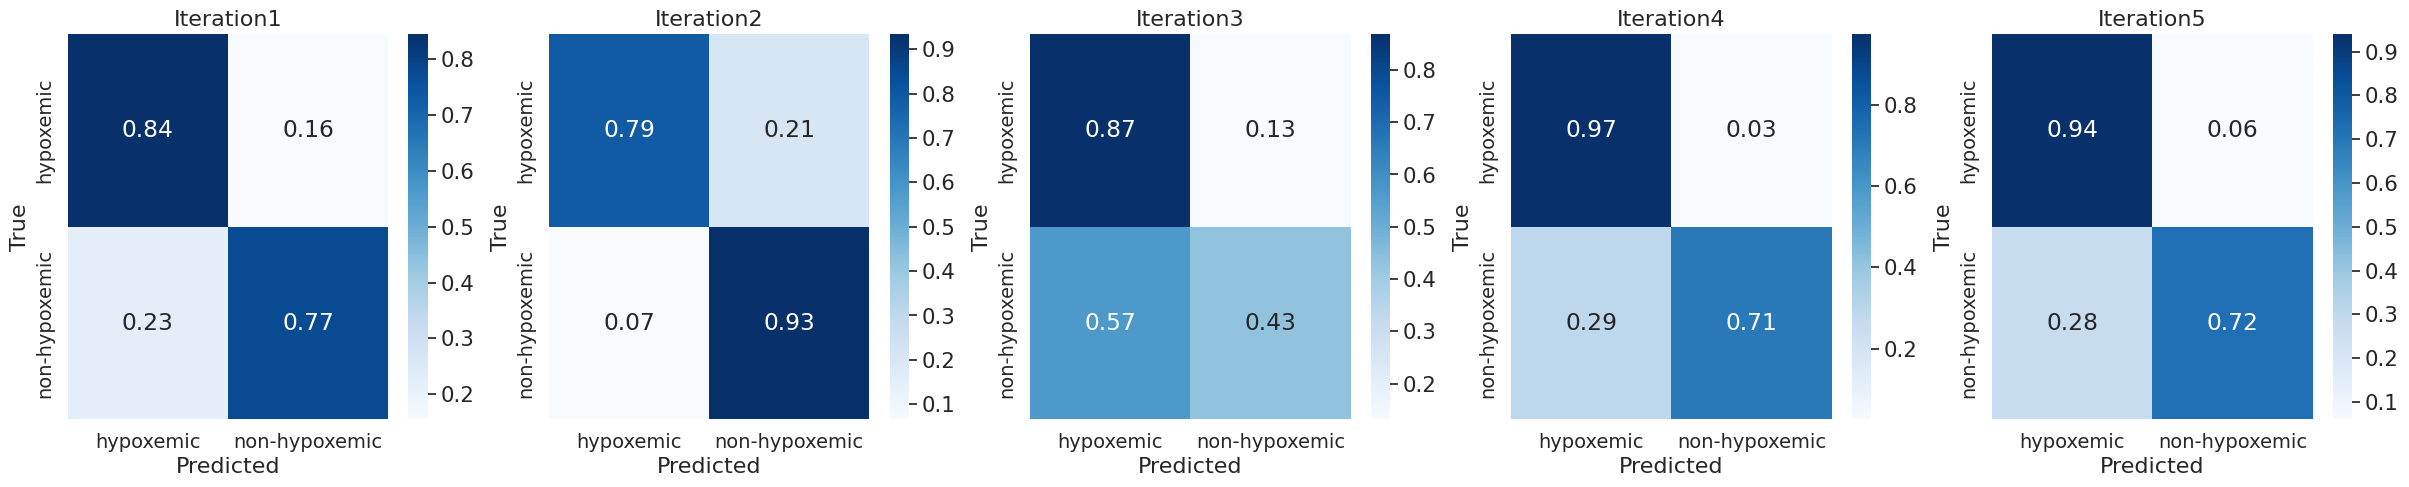

In [18]:
from collections import Counter
import pandas as pd
val_st_percentage = [0, 0.2, 0.4, 0.6, 0.8]

# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Iteration', 'Pos_Count', 'Pos_Count_train', 'Neg_Count', 'Neg_Count_train', 'Sensitivity', 'Specificity', 'Precision', 'F1_Score'])

# shp_rd_all = ['S4_R1_sp2022',
#               'S10_R1_sp2022',
#                 # 'S1_R1_sp2021',
#                 'S5_R2_su2020',
#                 'S5_R1_su2020',
#                 'S2_R2_sp2022',
#                 'S1_R2_sp2021',
#                 'S10_R2_sp2022',
#                 'S4_R2_sp2022',
#                 'S1_R3_sp2021',
#                 ]
shp_rd_all = ['S4_R1_sp2022',
              'S10_R1_sp2022',
                # 'S1_R1_sp2021',
                'S5_R1_su2020',
                'S2_R2_sp2022',
                'S5_R2_su2020',
                # 'S1_R2_sp2021',
                'S10_R2_sp2022',
                'S4_R2_sp2022',
                'S1_R3_sp2021',
                ]

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 5))
for iteration, st_ratio in enumerate(val_st_percentage):
    print(f'++++++++++++++Iteration {iteration+1}+++++++++++++++++++')
    X_train, X_test, y_train, y_test, _, _, _, _  = dataset_api.prepare_dataset(avg_ratio_740_dataset, avg_ratio_850_dataset, 
                    avg_RoR_dataset, SaO2_labels_linear_interp, shp_rd_all, label_encoder=label_encoder, val_ratio=0.2, val_st_per=st_ratio, verbose=0)
    print(f'Train sample: {len(X_train)}, Test sample: {len(X_test)}')

    model = FusionMLP_bi_cla(input_size, num_rep, cla_hidden_size, rep_hidden_size).to(device)
    path = f'../results/classification/{layer_arch}/{layer_arch}_itr{iteration+1}.pth'
    model.load_state_dict(torch.load(path))

    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.int64).to(device).squeeze()
    y_pred = model.predict(X_test).squeeze()
    sensitivity, specificity, precision, f1 = calculate_metrics(y_test.cpu().numpy(), y_pred.cpu().numpy())
    print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")
    y_pred = label_encoder.inverse_transform(y_pred.cpu().numpy())
    y_test = label_encoder.inverse_transform(y_test.cpu().numpy())
    y_train = label_encoder.inverse_transform(y_train)
    class_counts = Counter(y_test)
    print(class_counts)
    class_counts_train = Counter(y_train)
    print(class_counts_train)
    pos_cnt, neg_cnt = class_counts['hypoxic'], class_counts['non-hypoxic']
    pos_cnt_train, neg_cnt_train = class_counts_train['hypoxic'], class_counts_train['non-hypoxic']

    plot_norm_confusion_matrix(axs[iteration], y_test, y_pred, f'Iteration{iteration+1}')

    # Append the results to the dataframe
    new_row = {'Iteration': iteration+1, 'Pos_Count': pos_cnt, 'Pos_Count_train': pos_cnt_train, 'Neg_Count': neg_cnt, 'Neg_Count_train': neg_cnt_train,
                'Sensitivity': f'{sensitivity:.2f}', 'Specificity': f'{specificity:.2f}', 'Precision': f'{precision:.2f}', 'F1_Score': f'{f1:.2f}'}
    results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

    path = f'../results/npj_submission/norm_confusion_matrix.png'
    plt.savefig(path, dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight', pad_inches=0.1)

In [19]:
results_df.to_csv(f'../results/classification/{layer_arch}/classification_metric.csv')
results_df

,Iteration,Pos_Count,Pos_Count_train,Neg_Count,Neg_Count_train,Sensitivity,Specificity,Precision,F1_Score
0,1,1238,8246,1234,2413,0.84,0.77,0.79,0.82
1,2,1943,7406,484,3253,0.79,0.93,0.98,0.87
2,3,2200,7103,227,3600,0.87,0.43,0.94,0.90
3,4,1992,7391,480,3313,0.97,0.71,0.93,0.95
4,5,1374,8143,1098,2560,0.94,0.72,0.81,0.87


### Confusion matrix

++++++++++++++Iteration 1+++++++++++++++++++
Sensitivity: 0.8449, Specificity: 0.7731, Precision: 0.7888, F1 Score: 0.8159
++++++++++++++Iteration 2+++++++++++++++++++
Sensitivity: 0.7890, Specificity: 0.9339, Precision: 0.9796, F1 Score: 0.8740
++++++++++++++Iteration 3+++++++++++++++++++
Sensitivity: 0.8682, Specificity: 0.4317, Precision: 0.9367, F1 Score: 0.9012
++++++++++++++Iteration 4+++++++++++++++++++
Sensitivity: 0.9734, Specificity: 0.7104, Precision: 0.9331, F1 Score: 0.9528
++++++++++++++Iteration 5+++++++++++++++++++
Sensitivity: 0.9396, Specificity: 0.7250, Precision: 0.8104, F1 Score: 0.8702


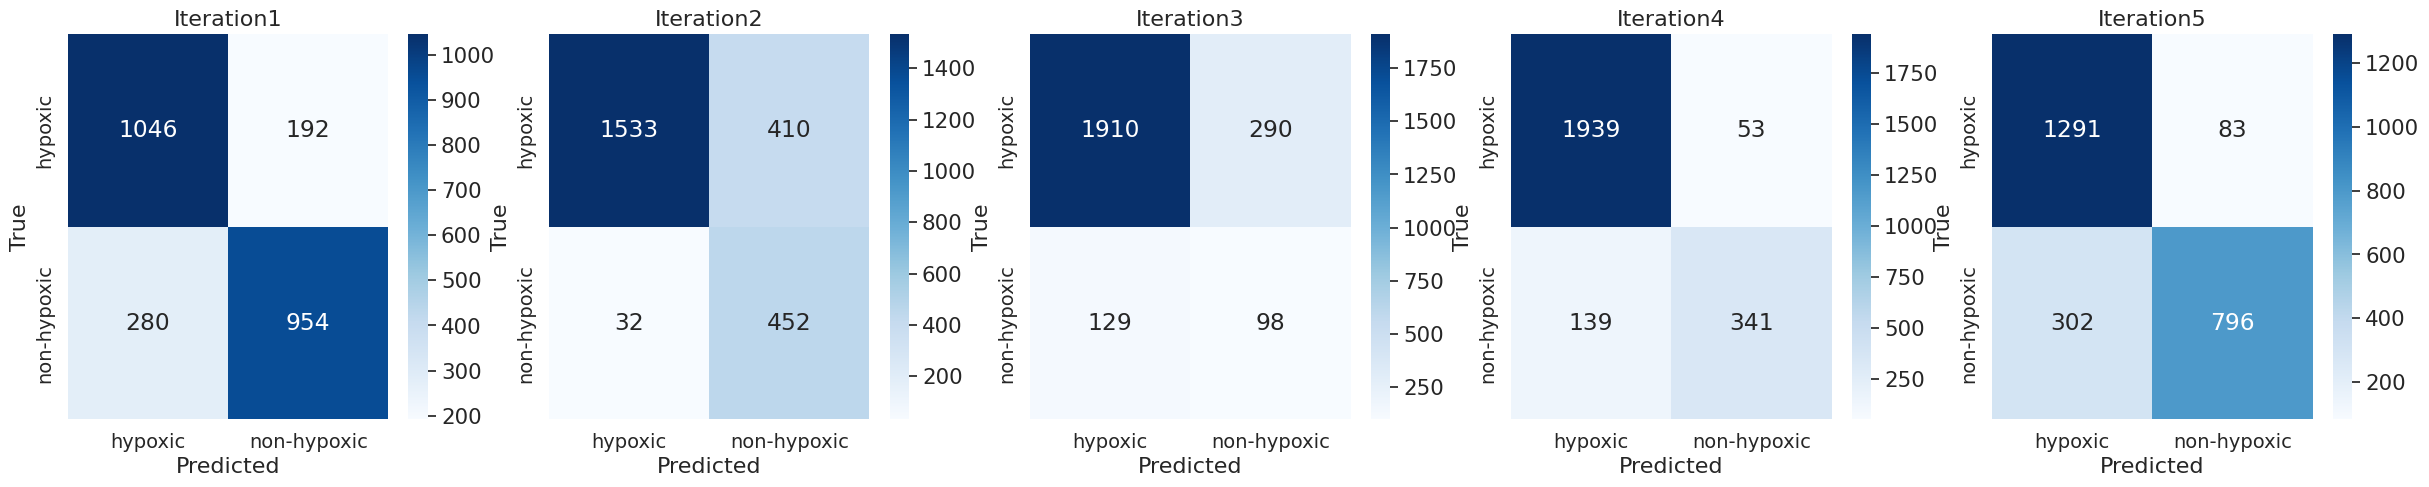

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 5))
for iteration, st_ratio in enumerate(val_st_percentage):
    print(f'++++++++++++++Iteration {iteration+1}+++++++++++++++++++')
    X_train, X_test, y_train, y_test, _, _, _, _  = dataset_api.prepare_dataset(avg_ratio_740_dataset, avg_ratio_850_dataset, 
                    avg_RoR_dataset, SaO2_labels_linear_interp, shp_rd_all, label_encoder=label_encoder, val_ratio=0.2, val_st_per=st_ratio, verbose=0)

    model = FusionMLP_bi_cla(input_size, num_rep, cla_hidden_size, rep_hidden_size).to(device)
    path = f'../results/classification/{layer_arch}/{layer_arch}_itr{iteration+1}.pth'
    model.load_state_dict(torch.load(path))

    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.int64).to(device).squeeze()
    y_pred = model.predict(X_test).squeeze()
    sensitivity, specificity, precision, f1 = calculate_metrics(y_test.cpu().numpy(), y_pred.cpu().numpy())
    print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")
    y_pred = label_encoder.inverse_transform(y_pred.cpu().numpy())
    y_test = label_encoder.inverse_transform(y_test.cpu().numpy())
    plot_confusion_matrix(axs[iteration], y_test, y_pred, f'Iteration{iteration+1}')
path = f'../results/npj_submission/confusion_matrix.png'
plt.savefig(path, dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight', pad_inches=0.1)

## ROC curve

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(ax, y_true, y_scores, iteration):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    ax.plot(fpr, tpr, label=f'auc={auc:.2f}', linewidth=3, color='red')  # Update the linewidth parameter
    ax.set_title(f'Iteration {iteration}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0, 1], [0, 1], linestyle='--', color='orange')
    ax.legend(fontsize=16, loc='lower right')

def plot_roc_curve_all_itr(y_test_dict, y_scores_dict):
    fig, ax = plt.subplots(figsize=(10, 10))
    for iteration, y_test in y_test_dict.items():
        y_scores = y_scores_dict[iteration]
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc = roc_auc_score(y_test, y_scores)
        ax.plot(fpr, tpr, label=f'{iteration} auc={auc:.2f}', linewidth=3)
    ax.set_title(f'ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0, 1], [0, 1], linestyle='--', color='grey', linewidth=3)
    ax.legend(fontsize=16)
    path = f'../results/npj_submission/roc_curve.png'
    plt.savefig(path, dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight', pad_inches=0.1)

++++++++++++++Iteration 1+++++++++++++++++++
++++++++++++++Iteration 2+++++++++++++++++++
++++++++++++++Iteration 3+++++++++++++++++++
++++++++++++++Iteration 4+++++++++++++++++++
++++++++++++++Iteration 5+++++++++++++++++++


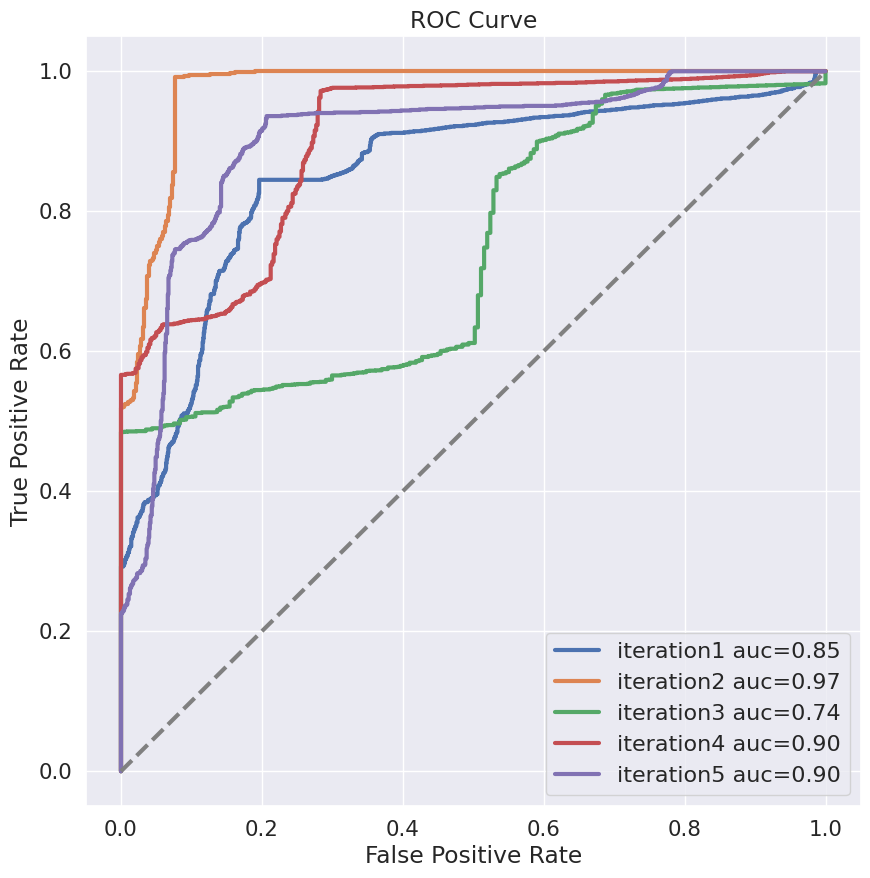

In [22]:
val_st_percentage = [0, 0.2, 0.4, 0.6, 0.8]

# fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
y_test_dict, y_scores_dict = {}, {}
for iteration, st_ratio in enumerate(val_st_percentage):
    print(f'++++++++++++++Iteration {iteration+1}+++++++++++++++++++')
    _, X_test, _, y_test, _, _, _, _  = dataset_api.prepare_dataset(avg_ratio_740_dataset, avg_ratio_850_dataset, 
                    avg_RoR_dataset, SaO2_labels_linear_interp, shp_rd_all, label_encoder=label_encoder, val_ratio=0.2, val_st_per=st_ratio, verbose=0)

    model = FusionMLP_bi_cla(input_size, num_rep, cla_hidden_size, rep_hidden_size).to(device)
    path = f'../results/classification/{layer_arch}/{layer_arch}_itr{iteration+1}.pth'
    model.load_state_dict(torch.load(path))

    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.int64).to(device).squeeze()
    y_scores = model.predict_proba(X_test).squeeze()
    y_test_dict[f'iteration{iteration+1}'] = y_test.cpu().numpy()
    y_scores_dict[f'iteration{iteration+1}'] = y_scores.cpu().numpy()
plot_roc_curve_all_itr(y_test_dict, y_scores_dict)

## CM + ROC w/ ci

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import resample

# ROC curve with confidence intervals
def plot_roc_curve_with_ci(ax, y_true, y_scores, iteration, n_bootstraps=1000, ci=95):
    # Original ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    
    
    # Bootstrap for confidence intervals
    bootstrapped_aucs = []
    rng = np.random.RandomState(42)  # for reproducibility
    for i in range(n_bootstraps):
        # Bootstrap by sampling with replacement on the indices of y_true
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            # We need both classes
            continue
        auc = roc_auc_score(y_true[indices], y_scores[indices])
        bootstrapped_aucs.append(auc)

    sorted_scores = np.array(bootstrapped_aucs)
    sorted_scores.sort()
    
    # Confidence interval
    lower = np.percentile(sorted_scores, (100 - ci) / 2)
    upper = np.percentile(sorted_scores, 100 - (100 - ci) / 2)
    # ax.fill_between(fpr, tpr - lower, tpr + upper, color='grey', alpha=0.3)
    ax.plot(fpr, tpr, label=f'AUC={auc:.2f}\n{ci}% CI: [{lower:.2f}-{upper:.2f}]', linewidth=3, color='red')
    # ax.plot([], [], label=f'{ci}% CI: [{lower:.2f}-{upper:.2f}]', alpha=0.3, linewidth=10, color='grey')

    # Set titles and labels
    ax.set_title(f'Iteration {iteration}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0, 1], [0, 1], linestyle='--', color='orange')
    ax.legend(fontsize=16, loc='lower right')

++++++++++++++Iteration 1+++++++++++++++++++
Train sample: 10659, Test sample: 2472
Sensitivity: 0.8449, Specificity: 0.7731, Precision: 0.7888, F1 Score: 0.8159
Counter({'hypoxic': 1238, 'non-hypoxic': 1234})
++++++++++++++Iteration 2+++++++++++++++++++
Train sample: 10659, Test sample: 2427
Sensitivity: 0.7890, Specificity: 0.9339, Precision: 0.9796, F1 Score: 0.8740
Counter({'hypoxic': 1943, 'non-hypoxic': 484})
++++++++++++++Iteration 3+++++++++++++++++++
Train sample: 10703, Test sample: 2427
Sensitivity: 0.8682, Specificity: 0.4317, Precision: 0.9367, F1 Score: 0.9012
Counter({'hypoxic': 2200, 'non-hypoxic': 227})
++++++++++++++Iteration 4+++++++++++++++++++
Train sample: 10704, Test sample: 2472
Sensitivity: 0.9734, Specificity: 0.7104, Precision: 0.9331, F1 Score: 0.9528
Counter({'hypoxic': 1992, 'non-hypoxic': 480})
++++++++++++++Iteration 5+++++++++++++++++++
Train sample: 10703, Test sample: 2472
Sensitivity: 0.9396, Specificity: 0.7250, Precision: 0.8104, F1 Score: 0.8702
C

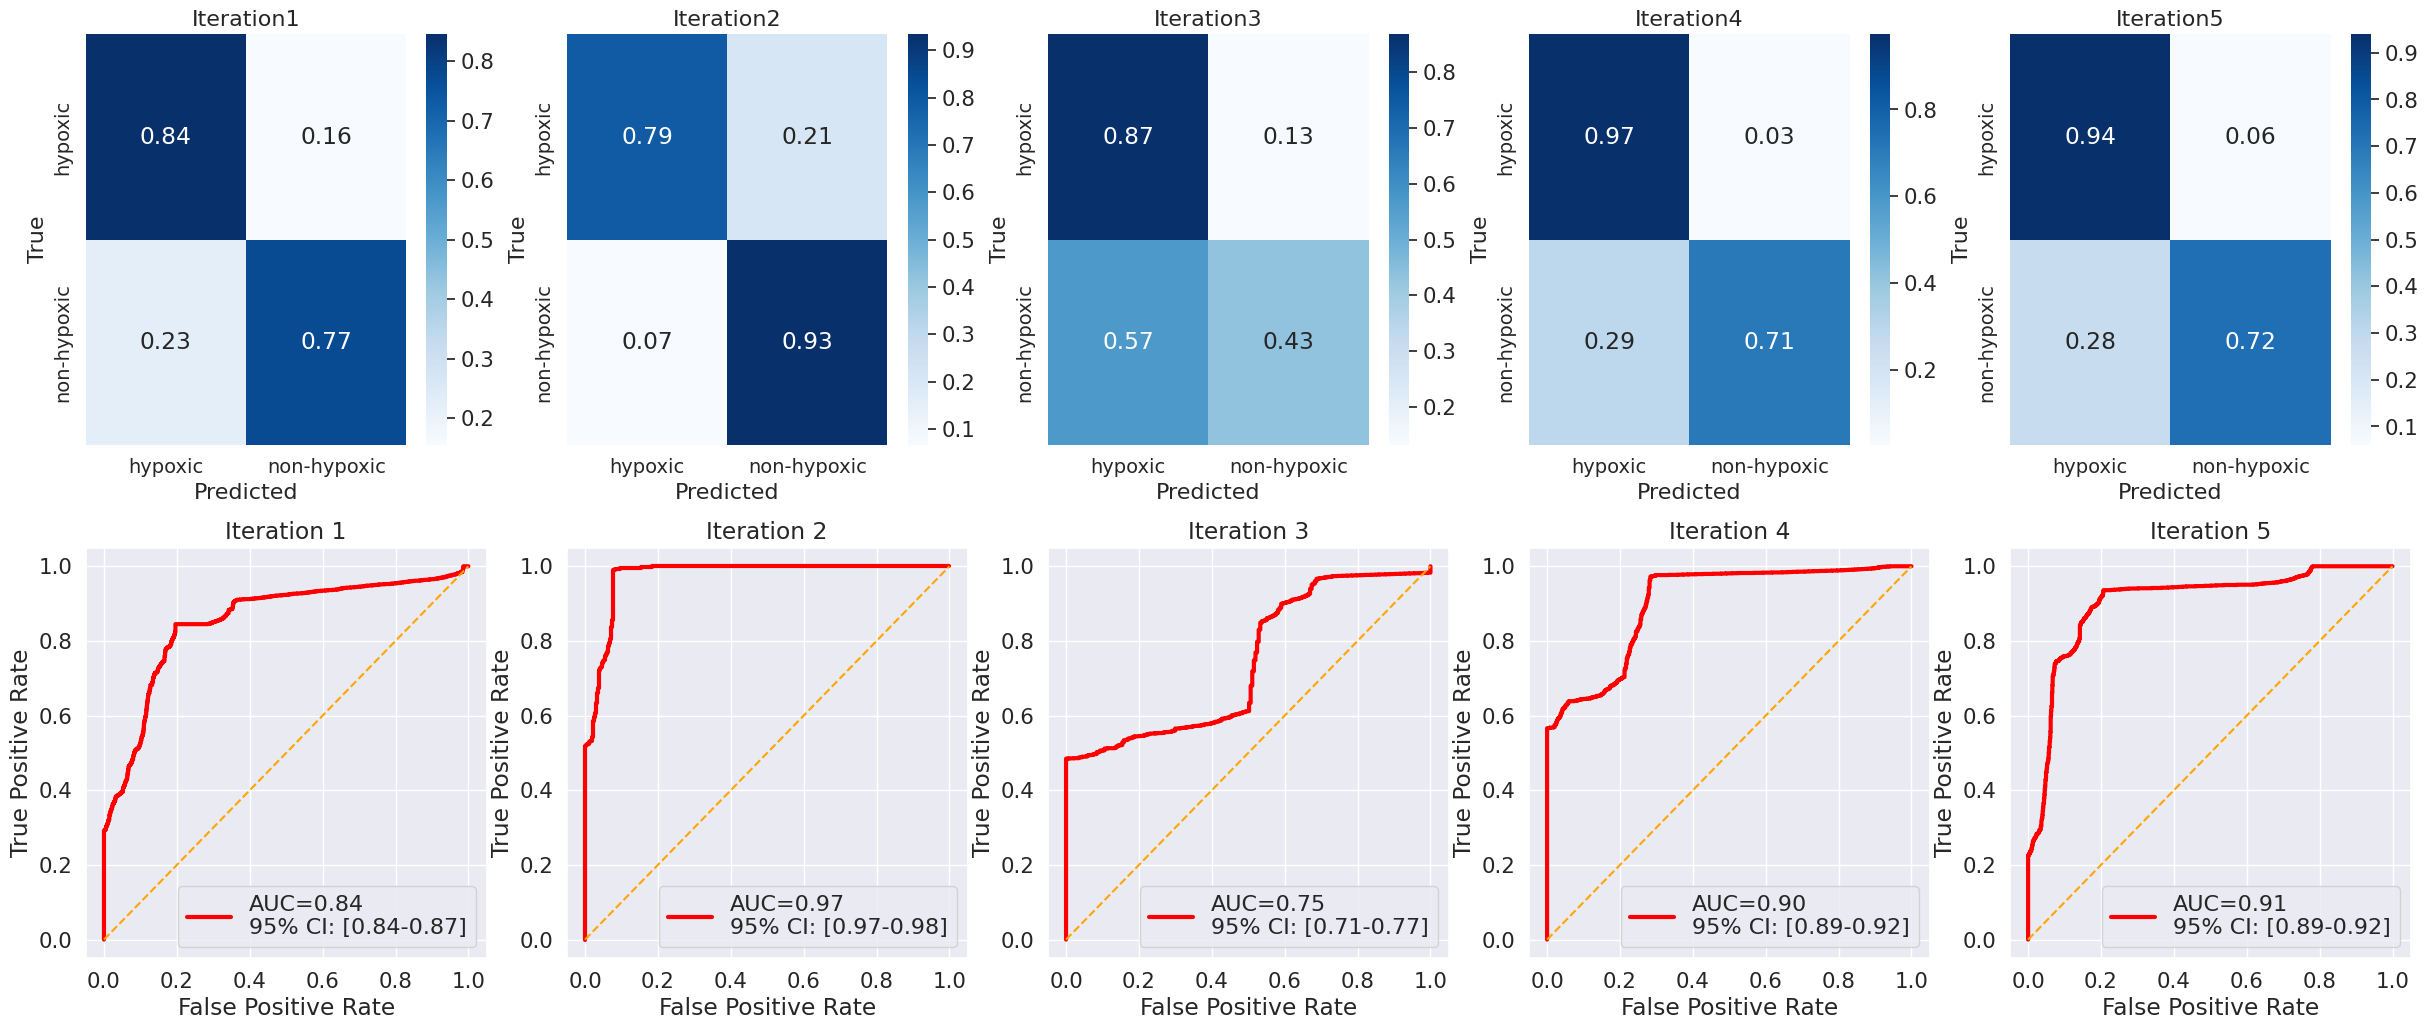

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(30, 12))
fig.subplots_adjust(hspace=0.25)

for iteration, st_ratio in enumerate(val_st_percentage):
    print(f'++++++++++++++Iteration {iteration+1}+++++++++++++++++++')
    X_train, X_test, y_train, y_test, _, _, _, _  = dataset_api.prepare_dataset(avg_ratio_740_dataset, avg_ratio_850_dataset, 
                    avg_RoR_dataset, SaO2_labels_linear_interp, shp_rd_all, label_encoder=label_encoder, val_ratio=0.2, val_st_per=st_ratio, verbose=0)
    print(f'Train sample: {len(X_train)}, Test sample: {len(X_test)}')

    model = FusionMLP_bi_cla(input_size, num_rep, cla_hidden_size, rep_hidden_size).to(device)
    path = f'../results/classification/{layer_arch}/{layer_arch}_itr{iteration+1}.pth'
    model.load_state_dict(torch.load(path))

    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.int64).to(device).squeeze()
    y_pred = model.predict(X_test).squeeze()
    y_scores = model.predict_proba(X_test).squeeze()
    plot_roc_curve_with_ci(axs[1][iteration], y_test.cpu().numpy(), y_scores.cpu().numpy(), iteration+1, ci=95)

    sensitivity, specificity, precision, f1 = calculate_metrics(y_test.cpu().numpy(), y_pred.cpu().numpy())
    print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")
    y_pred = label_encoder.inverse_transform(y_pred.cpu().numpy())
    y_test = label_encoder.inverse_transform(y_test.cpu().numpy())
    class_counts = Counter(y_test)
    print(class_counts)
    pos_cnt, neg_cnt = class_counts['hypoxic'], class_counts['non-hypoxic']

    plot_norm_confusion_matrix(axs[0][iteration], y_test, y_pred, f'Iteration{iteration+1}')

    # Append the results to the dataframe
    new_row = {'Iteration': iteration+1, 'Pos_Count': pos_cnt, 'Neg_Count': neg_cnt, 
                'Sensitivity': f'{sensitivity:.2f}', 'Specificity': f'{specificity:.2f}', 'Precision': f'{precision:.2f}', 'F1_Score': f'{f1:.2f}'}
    results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

path = f'../results/npj_submission/confusion_matrix.png'
plt.savefig(path, dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight', pad_inches=0.1)